In [1]:
import numpy as np
from math import sin, pi, sqrt
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
def setgrid(nz, zmax, zfac):
    # construct regularly or geometrically spaced 1D grid
    # z(n)-z(1) = 2*z(1)*(zfac**(n-1)-1)/(zfac-1)
    # choice of z(1) and z(2) is compatible with conductionQ
  
    z = np.zeros(nz+1)
  
    if zfac>1.:
        dz = zmax/(3.+2.*zfac*(zfac**(nz-2)-1.)/(zfac-1.))
        z[1] = dz
        z[2] = 3*z[1]
        for i in range(3,nz+1):
            z[i] = (1.+zfac)*z[i-1] - zfac*z[i-2]
            # z[i] = z[i-1] + zfac*(z[i-1]-z[i-2]) # equivalent
    else:
        dz = zmax/nz
        for i in range(1,nz+1):
            z[i] = (i-0.5)*dz  

    return z



def heatflux_from_temperature(nz, z, T, k):
    # calculates heat flux from temperature profile
    # like k, the heat flux H is defined mid-point

    H = np.zeros(nz+1)
    # H[1] = -k[1] * (T[1]-Tsurf) / z[1]
    H[1] = 0. # to avoid ill-defined value
    for j in range(2,nz+1):
        H[j] = -k[j] * (T[j]-T[j-1]) / (z[j]-z[j-1])

    return H

In [3]:
def conductionT(nz,z,dt,T,Tsurf,Tsurfp1,ti,rhoc,Fgeotherm,Fsurf):
    """
    To calculate the diffusion of temperature into the ground with prescribed surface temperature and variable thermal properties on irregular grid
    Crank-Nicholson method

    Eqn: rhoc*T_t = (k*T_z)_z 
    BC (z=0): T=T(t)
    BC (z=L): heat flux = Fgeotherm

    nz = number of grid points
    dt = time step
    T = vertical temperature profile [K]  (in- and output)
    Tsurf, Tsurfp1 = surface temperatures at times n and n+1  
    ti = thermal inertia [J m^-2 K^-1 s^-1/2]  VECTOR
    rhoc = rho*c  heat capacity per volume [J m^-3 K^-1]  VECTOR
    ti and rhoc are not allowed to vary in the layers immediately adjacent to the surface or the bottom
    Fgeotherm = geothermal heat flux at bottom boundary [W/m^2]
    Fsurf = heat flux at surface [W/m^2]  (output)

    Grid: surface is at z=0
          T[1] is at z[1]; ...; T[i] is at z[i]
          k[i] is midway between z[i-1] and z[i]
          rhoc[i] is midway between z[i-1] and z[i]

    """

    # set some constants
    k = np.empty(nz+1)
    k = ti[:]**2 / rhoc[:] # thermal conductivity
    alpha = np.empty(nz+1)
    gamma = np.empty(nz+1)

    #for i in range(1,nz):
    #    buf = dt/(z[i+1]-z[i-1])
    #    alpha[i] = k[i+1]*buf*2./(rhoc[i]+rhoc[i+1])/(z[i+1]-z[i])
    #    gamma[i] = k[i]*buf*2./(rhoc[i]+rhoc[i+1])/(z[i]-z[i-1])
    alpha[1] = k[2] * dt / z[2] *2. / (rhoc[1]+rhoc[2]) / (z[2]-z[1])
    gamma[1] = k[1] * dt / z[2] *2. / (rhoc[1]+rhoc[2]) / z[1]

    buf2 = dt * 2. / (rhoc[2:-1]+rhoc[3:]) / (z[3:]-z[1:-2])
    alpha[2:-1] = k[3:] * buf2[:] / (z[3:]-z[2:-1])
    gamma[2:-1] = k[2:-1] * buf2[:] / (z[2:-1]-z[1:-2])
        
    alpha[nz] = 0.  # ensure b[nz] = 1+gamma[nz]
    gamma[nz] = dt * k[nz] / (2*rhoc[nz]) / (z[nz]-z[nz-1])**2
    
    # Set RHS
    r = np.empty(nz+1)
    r[1] = alpha[1]*T[2] + (1.-alpha[1]-gamma[1])*T[1] + gamma[1]*(Tsurf+Tsurfp1)
    #for i in range(2,nz):
    #    r[i] = gamma[i]*T[i-1] + (1.-alpha[i]-gamma[i])*T[i] + alpha[i]*T[i+1]
    r[2:-1] = gamma[2:-1]*T[1:-2] + (1.-alpha[2:-1]-gamma[2:-1])*T[2:-1] \
        + alpha[2:-1]*T[3:]
    r[nz] = 2*gamma[nz]*T[nz-1] + (1.-2*gamma[nz])*T[nz] + \
        2*dt/rhoc[nz]*Fgeotherm/(z[nz]-z[nz-1]) # assumes rhoc[nz+1]=rhoc[nz]

    # elements of tridiagonal matrix
    # special matrix for solve_banded
    D = np.zeros((3,nz))
    D[0,1:] = -alpha[1:-1]               # coefficient 'c'
    D[1,:] = 1. + alpha[1:] + gamma[1:]  # coefficient 'b'
    D[2,:-1] = -gamma[2:]                # coefficient 'a'
    #D[2,:-3] = -gamma[2:-2]
    D[1,-1] = 1. + 2*gamma[nz]
    D[2,-2] = -2*gamma[nz]
    
    # Solve for T at n+1
    T[1:] = scipy.linalg.solve_banded((1,1), D, r[1:])
    T[0] = Tsurfp1
    
    Fsurf = -k[1] * (T[1]-Tsurfp1) / z[1] # heat flux into surface
  

In [4]:
def plot_temperature_profile_2d(z, T):
    plt.figure(figsize=(8, 6))
    plt.plot(T, z, marker='.', linestyle='-', color='maroon')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Depth (m)')
    plt.title('Temperature Profile in the Ground (2D)')
    plt.gca().invert_yaxis() 
    plt.grid(True)
    plt.show()



Skin depth=  0.5438991941167934
zmax= 2.5
Time step= 495661.77900000004
Thermal inertia= 120.0  Period= 59479413.480000004


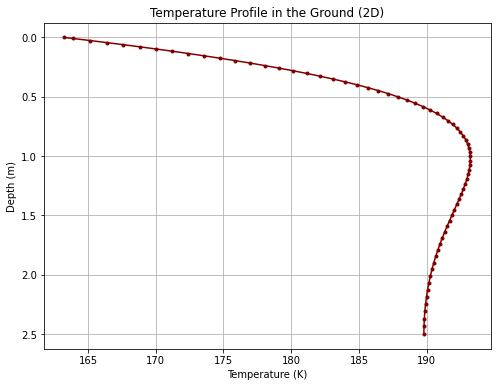

In [5]:
if __name__ == '__main__':
    
    Period = 88775.244*670  # [seconds]
    NSTEPS = 50000
    Fgeo = 0.  # [W/m^2]
    Ta=30.; Tm=190.

    STEPSPERSOL = 120
    dt = Period/STEPSPERSOL
    nz = 70; zmax = 2.5; zfac=1.02
    thIn = 120.  # thermal inertia

    rhocv = np.full(nz+1, 1200.*800.)   # (density) * (heat capacity)
    delta = thIn/rhocv[1]*sqrt(Period/pi)
    print('Skin depth= ',delta)
    print('zmax=',zmax)
    print('Time step=',dt)
    print('Thermal inertia=',thIn,' Period=',Period)

    fout = open('Tprofile','w') # temperature profile

    T = np.zeros(nz+1)
    ti = np.full(nz+1, thIn)

    z = setgrid(nz,zmax,zfac)
    np.savetxt('z', z[1:], fmt='%g', newline=" ")
      
    time = 0.
    Fsurf = 0.

    Tsurf = Tm + Ta*sin(2*pi*time/Period)

    for n in range(0,NSTEPS+1):
        time = (n+1)*dt     #   time at n+1;
        Tsurfp1 = Tm + Ta*sin(2*pi*time/Period) 
        conductionT(nz,z,dt,T,Tsurf,Tsurfp1,ti,rhocv,Fgeo,Fsurf)
        Tsurf = Tsurfp1

          # write 12 profiles from the last sol
        if n > NSTEPS-STEPSPERSOL:
            if n%10==9: # synched with test_Tprofile.m
                #print(time/Period, Tsurf)
                np.savetxt(fout,np.column_stack(T[:]),fmt=' %7.2f'*(nz+1) )

      # end of time loop

    fout.close()
    
    # Plotting temperature profile
    plot_temperature_profile_2d(z, T)
    

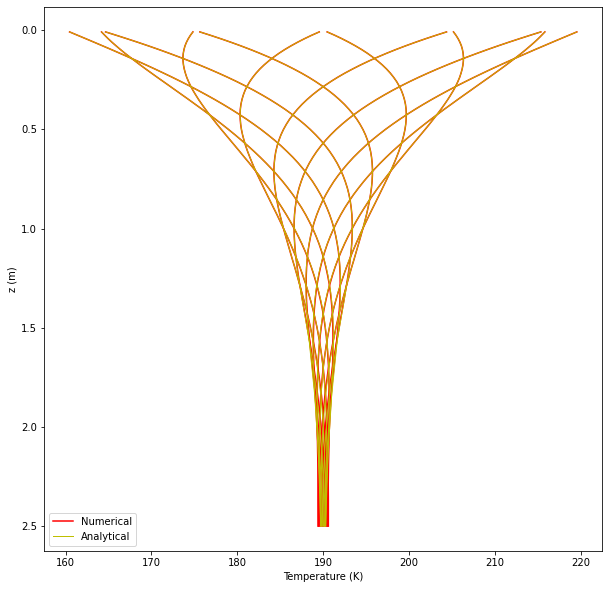

<Figure size 432x288 with 0 Axes>

In [6]:
wpth='./'

a = np.loadtxt(wpth + 'Tprofile')
T = a[:,1:]
z = np.loadtxt(wpth + 'z')


# plot profile
plt.figure(figsize=(10, 10))
plt.plot(T[0,:],z,'r-',label='Numerical')
for i in range(1,12):
    plt.plot(T[i,:],z,'r-')
        
plt.xlabel('Temperature (K)')
plt.ylabel('z (m)')
plt.gca().invert_yaxis()


# compare with analytical solution for sinusoidal surface temperature oscillation and semi-infinite domain
Ta=30.; Tm=190.; P=670.*88775.244
rhoc = 1200*800; thIn=120
delta = thIn/rhoc * np.sqrt(P/np.pi)   # skin depth
w = 2*np.pi/P
dt = P/12
TT = np.zeros(len(z))

for i in range(0,12):
    t = i*dt
    TT = Tm + Ta * np.exp(-z/delta) * np.sin(z/delta-w*t)
    if i==0:
        plt.plot(TT,z,'y-',linewidth=1,label='Analytical')
    else:
        plt.plot(TT,z,'y-',linewidth=1)
        


plt.legend()

plt.show()
plt.savefig('Tprofile_crankT.jpg')

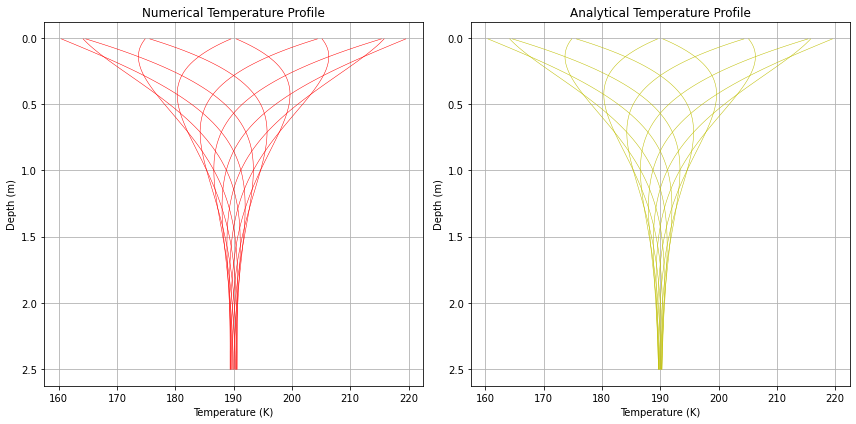

<Figure size 432x288 with 0 Axes>

In [7]:
# Load numerical temperature profiles and depth information
a = np.loadtxt('Tprofile')
T_numerical = a[:, 1:]
z = np.loadtxt('z')

# Plot numerical temperature profiles
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Subplot 1: Numerical solution
for i in range(12):
    plt.plot(T_numerical[i], z, 'r-', linewidth=0.5)
plt.xlabel('Temperature (K)')
plt.ylabel('Depth (m)')
plt.title('Numerical Temperature Profile')
plt.gca().invert_yaxis()
plt.grid(True)

# Analytical solution parameters
Ta = 30.
Tm = 190.
P = 670. * 88775.244
rhoc = 1200 * 800
thIn = 120
delta = thIn / rhoc * np.sqrt(P / np.pi)  # Skin depth
w = 2 * np.pi / P
dt = P / 12

# Calculate and plot analytical temperature profile
TT_analytical = np.zeros(len(z))
plt.subplot(1, 2, 2)  # Subplot 2: Analytical solution
for i in range(12):
    t = i * dt
    TT_analytical = Tm + Ta * np.exp(-z / delta) * np.sin(z / delta - w * t)
    plt.plot(TT_analytical, z, 'y-', linewidth=0.5)
plt.xlabel('Temperature (K)')
plt.ylabel('Depth (m)')
plt.title('Analytical Temperature Profile')
plt.gca().invert_yaxis()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig('Tprofile_crankT_sep.png',format='png')

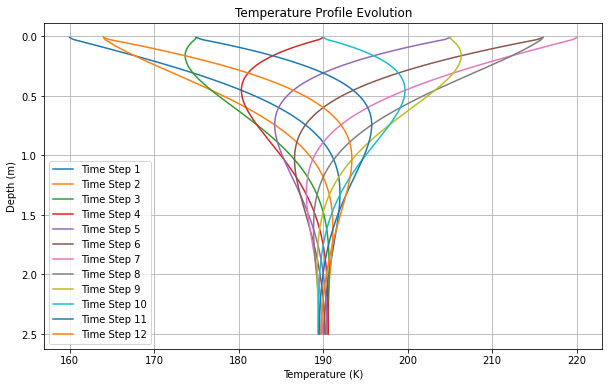

In [8]:


# Load temperature profile data
profile_data = np.loadtxt('Tprofile')
z = np.loadtxt('z')
time_profile = np.arange(len(profile_data))  # Assuming each row corresponds to a time step

# Plot temperature profiles
plt.figure(figsize=(10, 6))
for i in range(12):
    plt.plot(profile_data[i, :-1], z, label=f'Time Step {i+1}')  # Adjusted to match dimensions
plt.xlabel('Temperature (K)')
plt.ylabel('Depth (m)')
plt.title('Temperature Profile Evolution')
plt.legend()
plt.gca().invert_yaxis()  # Reverse the y-axis
plt.grid(True)
plt.show()
